In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import gi
gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [3]:
import sys
from clmm import modeling as m
from clmm.constants import Constants as clc

In [4]:
from astropy.cosmology import FlatLambdaCDM
astropy_cosmology_object = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
cosmo_ccl = m.cclify_astropy_cosmo(astropy_cosmology_object)

In [5]:
mass_Delta            = 200    # Mass defintion: mean matter density
cluster_mass          = 1.0e15 # Msun / h
cluster_concentration = 4.0
z_max                 = 3.0
z_cluster             = 1.0
z_source              = 2
alpha                 = 0.19 # log slope for the einasto profile

In [6]:
def compare(x, y_clmm, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(6, 4)}, title='title'):
    clmm_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    diff = y_nc/y_clmm - 1.
    print(title+'\nrel diff min: %e\nrel diff max: %e'%(min(abs(diff)), max(abs(diff))))
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    axs[0].set_title(title)
    axs[0].plot(x, y_clmm, label='clmm', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    axs[1].plot(x, diff, c='r')
    axs[1].axhline(0, ls=':', c='0', lw=.5)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, clmm_name))
    
    return fig, axs

In [7]:
#########################
# Initializing NumCosmo #
#########################
Ncm.cfg_init ()

##################
# Set Cosmology ##
##################
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
cosmo.omega_x2omega_k ()

cosmo.props.w       = -1.0
cosmo.props.H0 = cosmo_ccl['H0']

#constants_conversion = clc.SOLAR_MASS.value/cfg['TEST_CASE']['Msun[kg]']

cosmo.param_set_by_name ("H0",     cosmo_ccl['H0'])
cosmo.param_set_by_name ("Omegab", cosmo_ccl['Omega_b'])
cosmo.param_set_by_name ("Omegac", cosmo_ccl['Omega_c'])
cosmo.param_set_by_name ("w",      -1.0)
cosmo.param_set_by_name ("Omegak",  0.0)
cosmo.param_set_by_name ("Tgamma0", 0.0)


In [8]:
##########################
# Config Cluster/Source ##
##########################

# Correction factor for the critical mass density 
# NumCosmo uses the gravitational constant value, G, from CODATA 2018. 
# cluster_toolkit defines a macro for rho_c, which provides a different value in comparison to NumCosmo.
# This correction factor is applied to the cluster mass value.
cor_factor = 2.77533742639e+11 * m._patch_zevolution_cluster_toolkit_rho_m (1.0, 0.0) / Ncm.C.crit_mass_density_h2_solar_mass_Mpc3 ()
reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

# NumCosmo Density profile
nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
nc_nfw.props.MDelta = cluster_mass / cor_factor / cosmo.h ()
nc_nfw.props.cDelta = cluster_concentration

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
nc_ein.props.MDelta = cluster_mass / cor_factor / cosmo.h ()
nc_ein.props.cDelta = cluster_concentration
nc_ein.props.alpha = alpha

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

dist = Nc.Distance.new (z_max)
smd  = Nc.WLSurfaceMassDensity.new (dist)

smd.prepare (cosmo)


In [9]:
r     = np.logspace(-3,3,100) # Mpc/h
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)
nc_Sigma_nfw  = smd.sigma_array (nc_nfw, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)
clmm_Sigma_nfw = m.predict_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model='nfw')
clmm_Sigma_ein = m.predict_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model='einasto', alpha=alpha)


NFW
rel diff min: 2.731821e-10
rel diff max: 5.388714e-10
Einasto
rel diff min: 2.266577e-06
rel diff max: 6.151351e-03


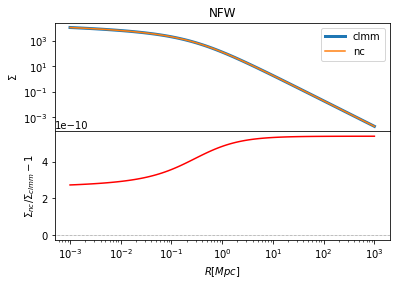

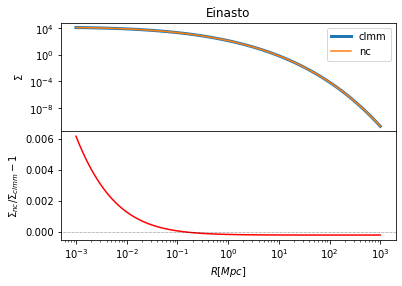

In [10]:
fig, axs = compare (r, clmm_Sigma_nfw, nc_Sigma_nfw, x_name='R [Mpc]', y_name=r'{\Sigma}', title='NFW')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
fig, axs = compare (r, clmm_Sigma_ein, nc_Sigma_ein, x_name='R [Mpc]', y_name=r'{\Sigma}', title='Einasto')
axs[0].set_xscale('log')
axs[0].set_yscale('log')


In [11]:
nc_DeltaSigma_ein  = smd.sigma_excess_array (nc_ein, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)
nc_DeltaSigma_nfw  = smd.sigma_excess_array (nc_nfw, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)

clmm_DeltaSigma_ein = m.predict_excess_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                   delta_mdef=mass_Delta, 
                                   halo_profile_model='einasto', alpha=alpha)

clmm_DeltaSigma_nfw = m.predict_excess_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                   delta_mdef=mass_Delta, 
                                   halo_profile_model='nfw')

NFW
rel diff min: 1.353584e-12
rel diff max: 2.935242e-09
Einasto
rel diff min: 1.821033e-06
rel diff max: 2.322992e-02


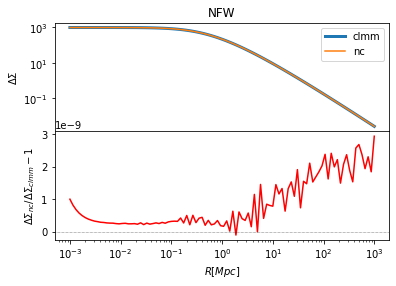

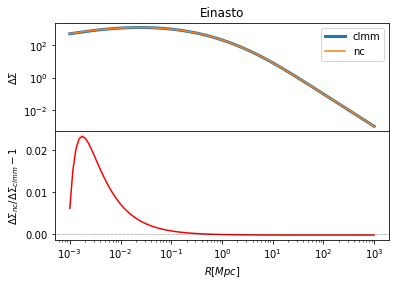

In [12]:
fig, axs = compare (r, clmm_DeltaSigma_nfw, nc_DeltaSigma_nfw, x_name='R [Mpc]', y_name=r'{\Delta\Sigma}', title='NFW')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
fig, axs = compare (r, clmm_DeltaSigma_ein, nc_DeltaSigma_ein, x_name='R [Mpc]', y_name=r'{\Delta\Sigma}', title='Einasto')
axs[0].set_xscale('log')
axs[0].set_yscale('log')


In [13]:
nc_gammat_nfw  = [smd.shear(nc_nfw, cosmo, r_i/cosmo.h(), z_source, z_cluster, z_cluster) for r_i in r]
nc_kappa_nfw  = [smd.convergence(nc_nfw, cosmo, r_i/cosmo.h(), z_source, z_cluster, z_cluster) for r_i in r]
nc_gt_nfw  = [smd.reduced_shear(nc_nfw, cosmo, r_i/cosmo.h(), z_source, z_cluster, z_cluster) for r_i in r]
nc_gammat_ein  = [smd.shear(nc_ein, cosmo, r_i/cosmo.h(), z_source, z_cluster, z_cluster) for r_i in r]
nc_kappa_ein  = [smd.convergence(nc_ein, cosmo, r_i/cosmo.h(), z_source, z_cluster, z_cluster) for r_i in r]
nc_gt_ein  = [smd.reduced_shear(nc_ein, cosmo, r_i/cosmo.h(), z_source, z_cluster, z_cluster) for r_i in r]


clmm_gammat_nfw = m.predict_tangential_shear(r, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='nfw', 
                               z_src_model='single_plane')
clmm_kappa_nfw = m.predict_convergence(r, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='nfw', 
                               z_src_model='single_plane')
clmm_gt_nfw = m.predict_reduced_tangential_shear(r, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='nfw', 
                               z_src_model='single_plane')
clmm_kappa_ein = m.predict_convergence(r, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='einasto',alpha=alpha, 
                               z_src_model='single_plane')
clmm_gammat_ein = m.predict_tangential_shear(r, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='einasto',alpha=alpha, 
                               z_src_model='single_plane')
clmm_gt_ein = m.predict_reduced_tangential_shear(r, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='einasto',alpha=alpha, 
                               z_src_model='single_plane')


NFW
rel diff min: 3.677124e-09
rel diff max: 6.716171e-09
NFW
rel diff min: 4.054111e-09
rel diff max: 4.319801e-09
NFW
rel diff min: 1.505842e-09
rel diff max: 1.369939e-07


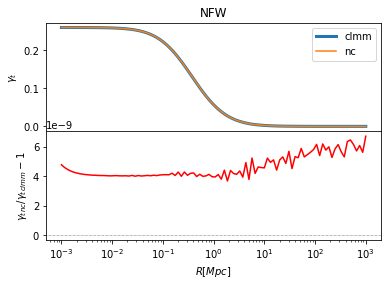

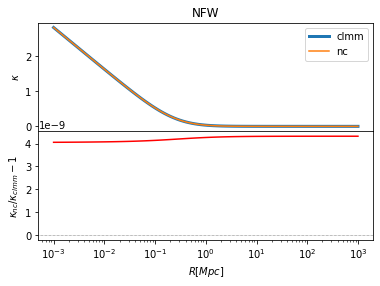

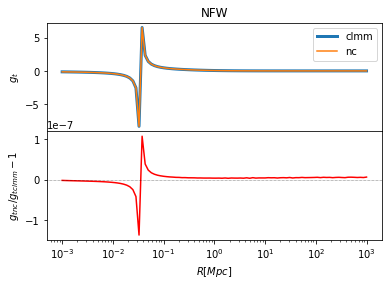

In [14]:
fig, axs = compare (r, clmm_gammat_nfw, nc_gammat_nfw, x_name='R [Mpc]', y_name=r'{\gamma_t}', title='NFW')
axs[0].set_xscale('log')
fig, axs = compare (r, clmm_kappa_nfw, nc_kappa_nfw, x_name='R [Mpc]', y_name=r'{\kappa}', title='NFW')
axs[0].set_xscale('log')
fig, axs = compare (r, clmm_gt_nfw, nc_gt_nfw, x_name='R [Mpc]', y_name=r'{g_t}', title='NFW')
axs[0].set_xscale('log')

Einasto
rel diff min: 1.817252e-06
rel diff max: 2.322993e-02
Einasto
rel diff min: 2.270358e-06
rel diff max: 6.151355e-03
Einasto
rel diff min: 9.518785e-06
rel diff max: 1.647511e-02


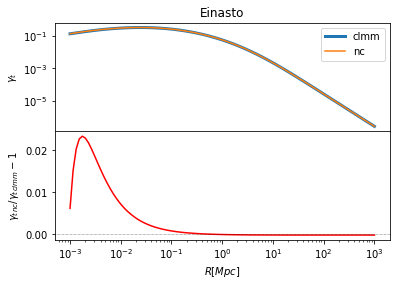

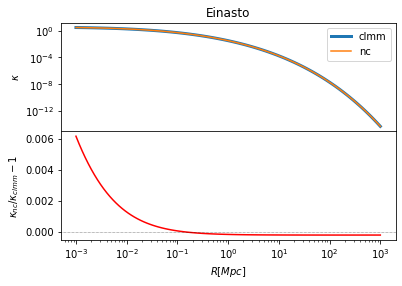

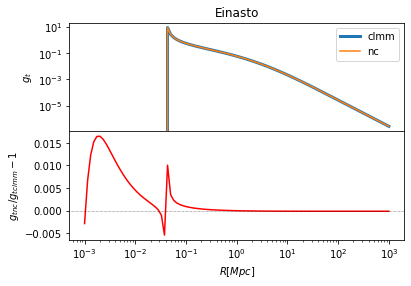

In [15]:
fig, axs = compare (r, clmm_gammat_ein, nc_gammat_ein, x_name='R [Mpc]', y_name=r'{\gamma_t}', title='Einasto')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
fig, axs = compare (r, clmm_kappa_ein, nc_kappa_ein, x_name='R [Mpc]', y_name=r'{\kappa}', title='Einasto')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
fig, axs = compare (r, clmm_gt_ein, nc_gt_ein, x_name='R [Mpc]', y_name=r'{g_t}', title='Einasto')
axs[0].set_yscale('log')
axs[0].set_xscale('log')